# YAPAY ZEKA PROJE ÖDEVİ GRUP NO : 10



*   ALGORİTMA ADI  :DCGAN
*   ÖRNEK DATASET ADI    :CelebA
*   ÖRNEK ADRESİ   :https://keras.io/examples/generative/dcgan_overriding_train_step/
*   ŞUBE           :2A

---
Grup Üyeleri :
*   Mustafa Özcan        [G201210090]
*   Yunus Emre Yılmaz    [G211210044]
*   Hatice Turan         [G21210048]
*   Yahya Haliloğlu      [G201210012]









# Algoritma Tanıtımı: *DCGAN* (Deep Convolutional Generative Adversarial Networks)
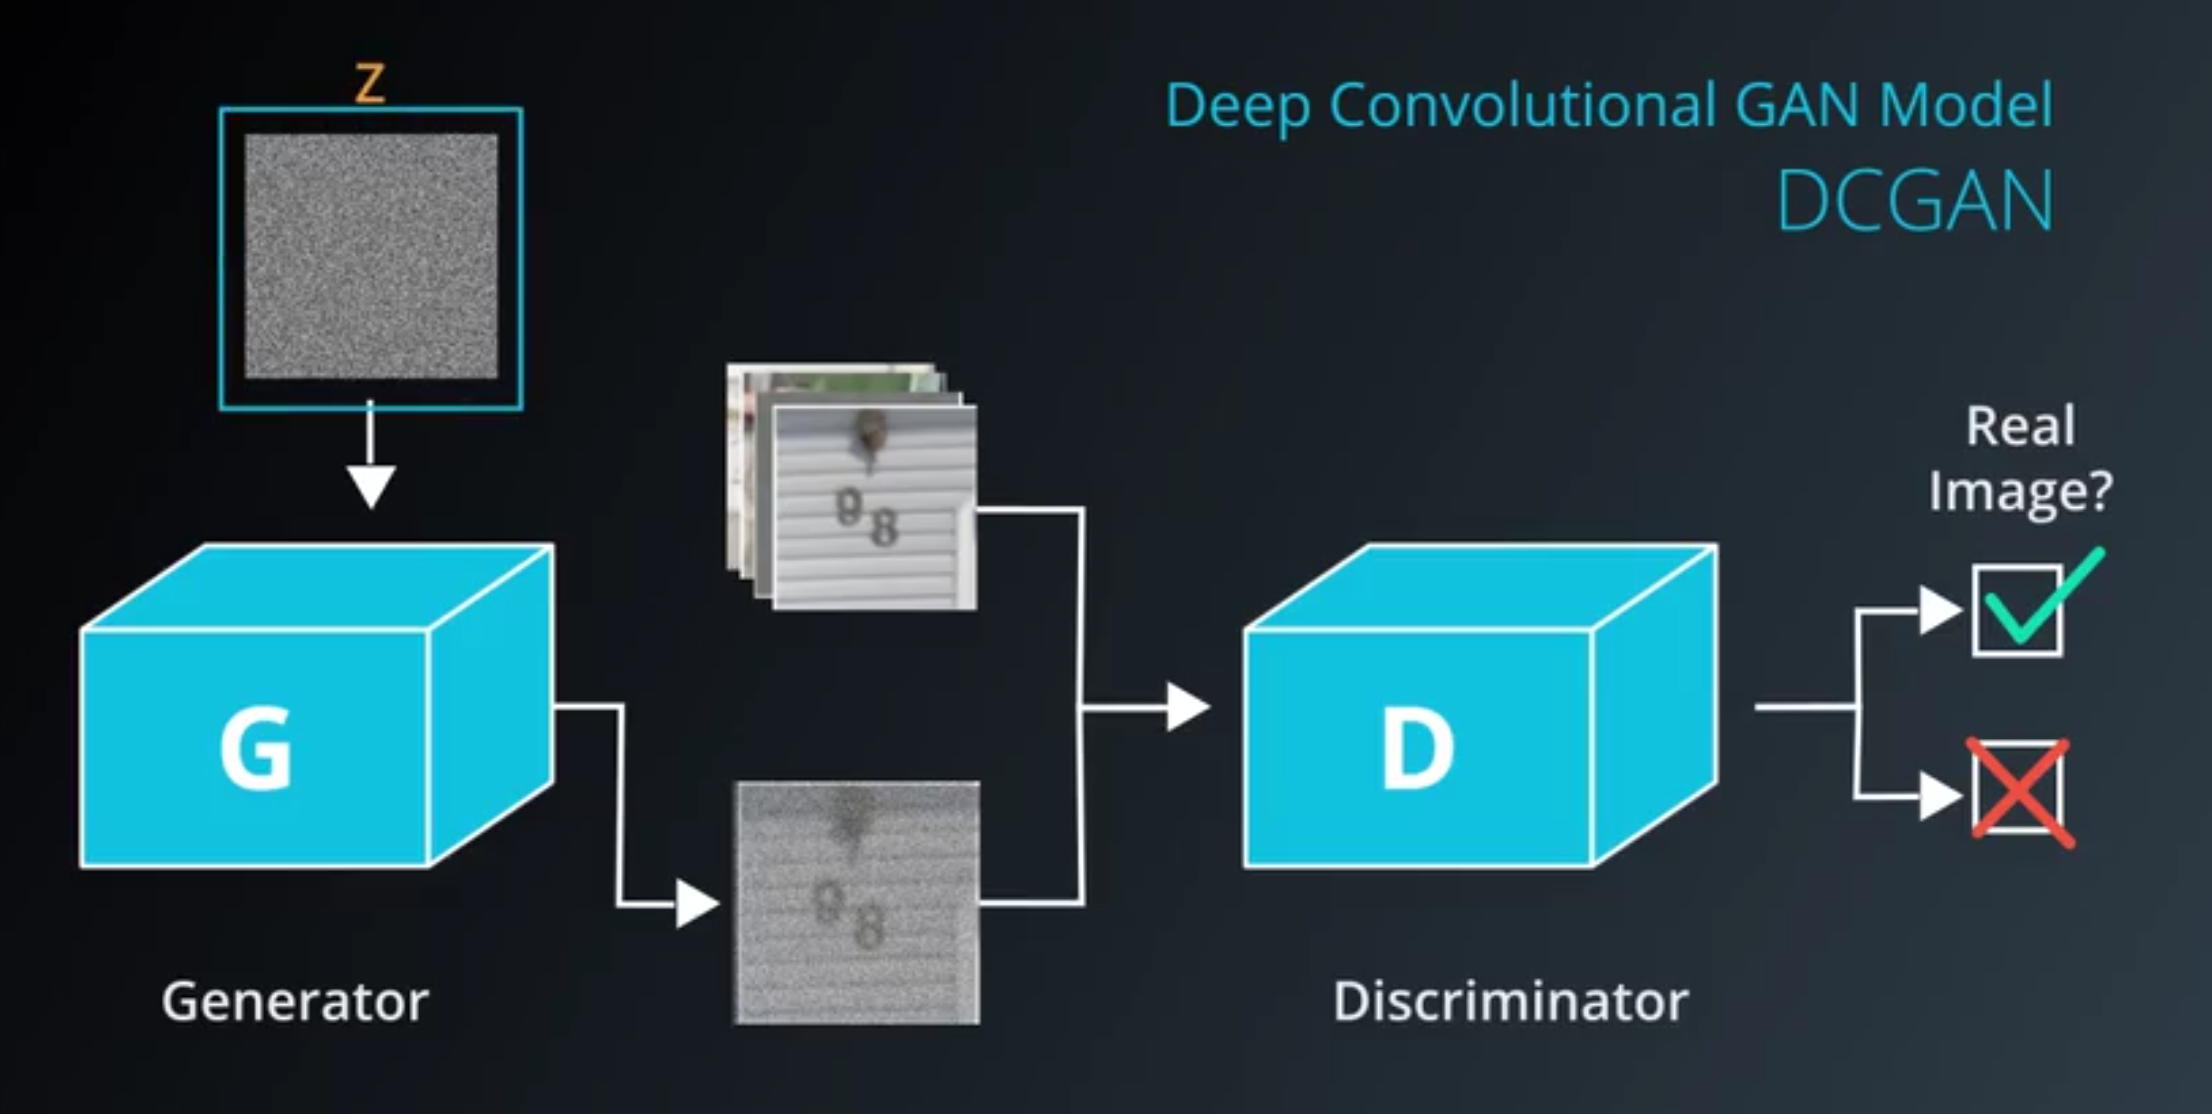

### DCGAN, ya da "Derin Evrişimli Üreteci Rekabetçi Ağlar", yapay zeka alanında kullanılan bir "Deep Learning" modelidir.Bu model iki temel bileşenden oluşur :"Generator" ve "Discriminator".

# Generator (Üreteç):
### Generator,rastgele gürültüden gerçekçi görüntüler üretmek için tasarlanmıştır.Giriş olarak alınan rastgele gürültüden gerçekçi görüntüler üretmek için tasarlanmıştır. Giriş olarak alınan rastgele bir vektörden  gerçek görüntülere benzeyen görüntüler üretir. Bu üretim süreci, katmanlar arasında evrişim işlemleri ve ters evrişim işlemleri kullanılarak gerçekleştirilir. Başlangıçta üretilen görüntüler genellikle gürültülü olabilir, ancak model eğitildikçe daha gerçekçi hale gelirler.

# Discriminator (Ayırt Edici):
### Ayırt edici, üretecinin ürettiği görüntüler ile gerçek görüntüler arasındaki farkı belirlemek için eğitilir. Bu ağ, verilen bir görüntünün ne kadar gerçekçi olduğunu değerlendirir ve bu gerçekçilik geribildirimi vasıtasıyla üreteciyi eğitmek için kullanır. Ayırt edici, gerçek görüntülerin etiketlerini (1 olarak "REAL") ve üretecinin ürettiği görüntülerin etiketlerini (0 olarak "FAKE") ayırt etmeye çalışır.

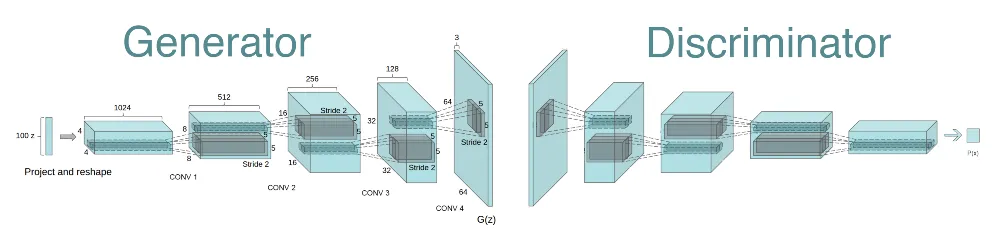

# SEÇİLEN ÖRNEĞİN ÇALIŞTIRILIMASI :
###Ödev Dokümanında belirtilen linklerden Generative Deep Learning  ***DCGAN to generate face images*** örneği seçilmiştir. Aşağıda örneğin çlaıştırılması ile ilgili bazı kısımlar eski kütüphaneler vs içerdiğinden düzenlenmiştir.



# DCGAN to generate face images

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/04/29<br>
**Last modified:** 2023/12/21<br>
**Description:** A simple DCGAN trained using `fit()` by overriding `train_step` on CelebA images.

## Setup

###Bu kısımda gerekli kütüphanelerimizi ayarlıyoruz.

In [ ]:
!pip install tensorflow

In [ ]:
!pip install matplotlib-venn

In [ ]:

#Importing Libraries
import random
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
from PIL import Image
import tensorflow  as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, UpSampling2D, Conv2D, BatchNormalization
from tensorflow.keras.layers import LeakyReLU, Dropout, ZeroPadding2D, Flatten, Activation
from tensorflow.keras.optimizers import Adam
import tqdm
import warnings
warnings.filterwarnings("ignore")
#Settings
sns.set(rc={"axes.facecolor":"#222233","figure.facecolor":"#222233"})
import tensorflow as tf
from tensorflow import keras  # Optional
from tensorflow import random
from tensorflow.keras import layers  # Import layers from TensorFlow's Keras
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile


## Prepare CelebA data
###Üzerinde çalıştığımız örneğin kullanmış olduğu dataset'in ismi **CelebA** şeklinde isimlendirilmiş olup bu dataset 1.3 GB boyutunda ünlü insan yüzleri içermektedir. Resimleri 64x64 olarak kullanacağız.


In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")


###Keras kütüphanesi yardımıyla datasetimize erişelim ve resimleri 64x64 hale getirip batch_size değerini ise 32 verelim. Batch Size değerinin 32 olması aynı anda işlenecek veri örneği sayının 32 olduğu manasına gelir.Bu gibi değerler deneme yanılma ile belirlenir.

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)


Found 202599 files belonging to 1 classes.


###Aşağıda datasetimizin içerisinde bir örnek görüntülüyoruz.

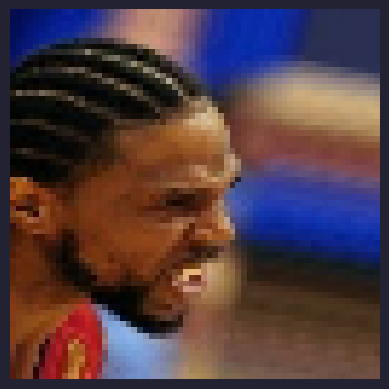

In [ ]:

for data in dataset:
    plt.axis("off")
    plt.imshow((data.numpy() * 255).astype("int32")[0])

    break


## Create the discriminator

###Bu bölümde Discriminator'ü (Ayırt Edici) oluşturuyoruz ve gerekli parametreleri belirtiyoruz.

In [ ]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

#discriminator.summary()

## Create the generator

###Ardından Generator oluşturuyoruz ve gerekli parametreleri belirtiyoruz.


In [ ]:
latent_dim = 128
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

#generator.summary()

## Override `train_step`
###Bu kısımda, bir Generative Adversarial Network (GAN) modelinin keras kullanılarak uygulanmasını gösterir. GAN, bir üreteci (generator) ve bir ayırt edici (discriminator) olmak üzere iki aşamadan oluşur. Eğitim adımında, gerçek görüntüler alınır ve rastgele örnekler kullanılarak sahte görüntüler üretir.
###Discriminator, gerçek ve sahte görüntüleri ayırt etmeye çalışırken, generator sahte görüntülerin gerçekçiliğini artırmak için eğitilir. Bu süreç, her iki ağı birbirine karşı mücadele ettirerek, daha gerçekçi görüntülerin üretilmesini sağlar. Sonuç olarak, discriminator ve generator birlikte gelişir ve daha gerçekçi sonuçlar elde edilir.

In [ ]:
#Code Sourced from keras sample.

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

## Create a callback that periodically saves generated images

## Train the end-to-end model

###Bu bölümde TensorFlow/Keras kullanılarak nasıl eğitileceğini gösterir. İlk olarak, eğitim döngüsü sayısı (epoch) belirlenir ve ayırt edici (discriminator) ile üretici (generator) ağlar için Adamax optimizatörleri tanımlanır. Kayıp hesaplamak için binary çapraz entropi kayıp fonksiyonu (BinaryCrossentropy) kullanılır. Model, ayırt edici ve üretici optimizatörleri ile kayıp fonksiyonu belirtilerek derlenir (compile). Son olarak, eğitim verisi (data) üzerinde belirtilen epoch sayısı kadar model eğitilir (fit), ve eğitim sürecinin metrikleri history değişkeninde saklanır.

In [ ]:
#Defining the number of epochs
epochs = 5 # In practice, use ~200 epochs
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

Epoch 1/5
1/1 [==============================] - 21s 21s/step - d_loss: 0.6949 - g_loss: 0.6947
Epoch 2/5
1/1 [==============================] - 0s 103ms/step - d_loss: 0.6694 - g_loss: 0.6701
Epoch 3/5
1/1 [==============================] - 0s 102ms/step - d_loss: 0.6637 - g_loss: 0.6543
Epoch 4/5
1/1 [==============================] - 0s 106ms/step - d_loss: 0.6651 - g_loss: 0.6537
Epoch 5/5
1/1 [==============================] - 0s 104ms/step - d_loss: 0.6822 - g_loss: 0.6614


##Şimdi modelimizden bir resim üretelim

In [ ]:
#Number of images to be generate
num_img=1

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("uretilen{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()

##Aşağıda modelimizin ürettiği resimleri görmektesiniz. (Sırasıyla125 epoch ,200 epoch ,170 epoch)

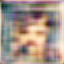

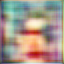

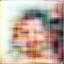

---



Some of the last generated images around epoch 30
(results keep improving after that):

![results](https://i.imgur.com/h5MtQZ7l.png)

#Seçilen  örnek çalışması tamamlandı.

## Şimdi veri setimizi değiştirelim

**Dataset Erişim İşlemleri** :bu kısımda datasetimizi indirme işlemleri yapıyoruz.(3GB) boyutlu yağlı boya portreleri

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'art-portraits:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1698586%2F2782287%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240515%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240515T045041Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8c7e1aafef7123113768f65cd520f6cc22405cdcccc1feb8d674d28f4df69ee568bbddcb04d46ef2fcbaacf86882a2fb85c53c229683a4e441aa4cb967b83262d7c19087242fdb08e5c3200e154f6aee90528b52ab1c18a6f1a880a2259d6e6215cb015661846df71daee8c9a3563a8d7b51f5294d9b662bbe94ea44ecb47b091830dc9d41196570c1723eb5828e455b451e22e1075f9b3cb6fb648d8fb2e4dbefbe0d5baf3369cdd71d8cc2a1d3c18f05524b4c99c1f20e7f8315b4f586bc22e3d8bb4b6f1de98beb98e3ed072235822a383feddd133a0f19bdf04c7394c23ca0c2a1861fb1abfe94477a5e893fe3e8065510d8c25fa310d57cf1ca2a95e1af'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 1397698045 bytes downloaded
Downloaded and uncompressed: art-portraits
Data source import complete.


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk("../input/art-portraits/Portraits/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
np.random.seed(42)

../input/art-portraits/Portraits/28db546f10043df3112510c40753b8b1c.jpg
../input/art-portraits/Portraits/40de813113765570ec742f54377a41adc.jpg
../input/art-portraits/Portraits/0e600f37b5e23e9e37ef3dda7d6c207cc.jpg
../input/art-portraits/Portraits/06c1587f425cf1bfe8c75d319c1d2ebdc.jpg
../input/art-portraits/Portraits/ca78d41ce4f7baffe473dd9c0440b195c.jpg
../input/art-portraits/Portraits/bb0bb74a18c610fea8bce5dabce3daf6c.jpg
../input/art-portraits/Portraits/4b5ba55852912e140cb72572719fcc36c.jpg
../input/art-portraits/Portraits/ac2d46195f322736b4199feddd271faac.jpg
../input/art-portraits/Portraits/fbfe7517259686deb8f5bf7f139b3781c.jpg
../input/art-portraits/Portraits/c9acb0c7ab6eece189286631d8b0cbbcc.jpg
../input/art-portraits/Portraits/f4bd5c202a6835814508ba75c499b6edc.jpg
../input/art-portraits/Portraits/8e8ae8d6e3b377c834546874606eefc7c.jpg
../input/art-portraits/Portraits/04f20f48980938260a1b5a89876b6989c.jpg
../input/art-portraits/Portraits/9d51825036fea1fd72fc16b71e40c62ac.jpg
../inp

##DATA LOADDING
###Dataseti yükleme işlemleri

In [ ]:

import tensorflow  as tf
import matplotlib.pyplot as plt

In [ ]:
#Importing data
data_path = "../input/art-portraits/Portraits/"
batch_s = 64
#Import as tf.Dataset
data = tf.keras.preprocessing.image_dataset_from_directory(data_path, label_mode = None, image_size = (64,64), batch_size = batch_s)

Found 4117 files belonging to 1 classes.


#Dataseti Görüntüleme
###Değiştirmiş olduğumuz datasetin içeriğinden örnek resimler görüntüleyelim.

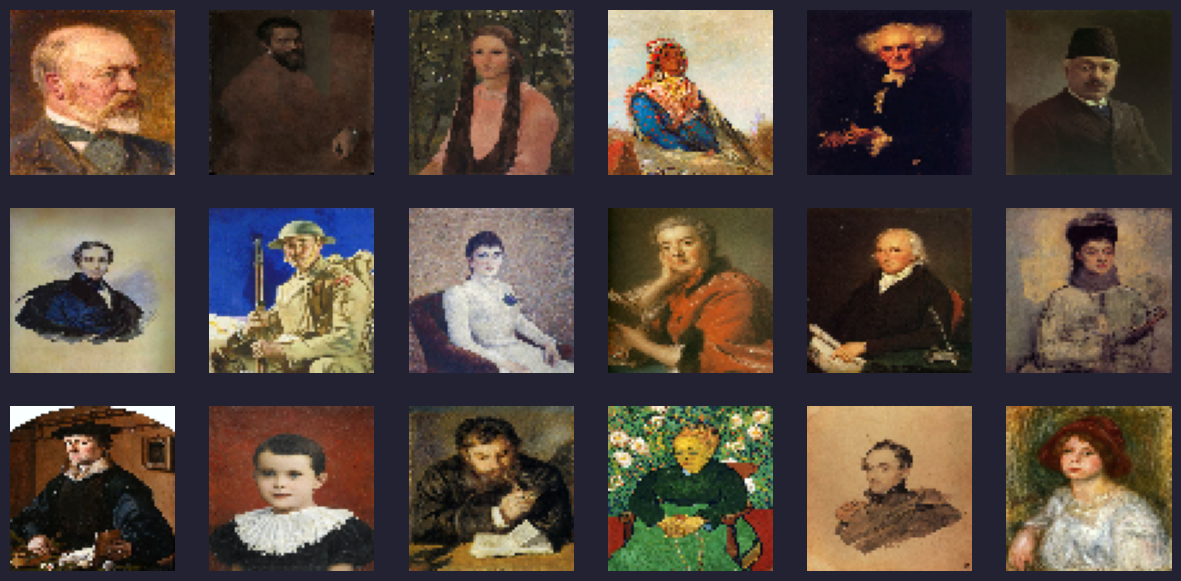

In [ ]:
#Defing a function to see images
def Show_Img(data):
    plt.figure(figsize=(15,15))
    for images in data.take(1):
        for i in range(18):
            ax = plt.subplot(6, 6, i + 1)
            ax.imshow(images[i].numpy().astype("uint8"))
            ax.axis("off")
#Plotting the images in dataset
Show_Img(data)



##**Normalizasyon**:
###Veri normalizasyonu için, veriler 0 ile 1 arasındaki aralığa dönüştürülür. Bu, hızlı yakınsamaya yardımcı olur ve bilgisayarın hesaplamaları daha hızlı yapmasını sağlar. Görüntüdeki her üç RGB kanalındaki piksel değerleri 0 ile 256 arasında olabilir. 255'e bölmek, bu değerleri 0 ile 1 arasındaki bir aralığa dönüştürür. Bunu yaparak, verilerin işlenmesi daha kolay hale gelir ve algoritmaların performansı artar.

In [ ]:
#Preprocessing the dataset for model
data = data.map(lambda x: x / 255.0)
data

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

#Generatorü Oluşturalım

In [ ]:
latent_dim = 100
g_resolution=2

#Building a Generator
generator = Sequential()
generator.add(Dense(4*4*256,activation="relu",input_dim=latent_dim))
generator.add(Reshape((4,4,256)))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(256,kernel_size=3,padding="same"))#
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(UpSampling2D())
generator.add(Conv2D(128,kernel_size=3,padding="same"))
generator.add(BatchNormalization(momentum=0.8))
generator.add(Activation("relu"))
generator.add(Conv2D(3,kernel_size=3,padding="same"))
generator.add(Activation("tanh"))

generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 4096)              413696    
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 256)         0         
                                                                 
 up_sampling2d_4 (UpSamplin  (None, 8, 8, 256)         0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 256)         590080    
                                                                 
 batch_normalization_8 (Bat  (None, 8, 8, 256)         1024      
 chNormalization)                                                
                                                                 
 activation_5 (Activation)   (None, 8, 8, 256)        


###Generator oluştu ama eğitilmedi henüz bakalım ne oluşturacak?

(-0.5, 63.5, 63.5, -0.5)

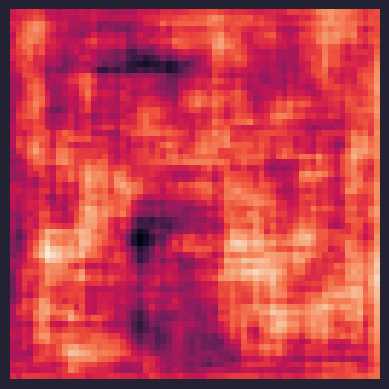

In [ ]:
#Creating a random seed and output from generator
seed = tf.random.normal([1, latent_dim])
Generated_Portrait = generator(seed, training=False)
#Plotting the image output of generator without training
plt.imshow(Generated_Portrait[0, :, :, 0])
plt.axis("off")

# **The Discriminator**

In [ ]:
#Building a Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(32, kernel_size=3, strides=2, input_shape=(64,64,3), padding="same"))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
discriminator.add(ZeroPadding2D(padding=((0,1),(0,1))))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
discriminator.add(BatchNormalization(momentum=0.8))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.25))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 32, 32, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 32, 32, 32)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 zero_padding2d_1 (ZeroPadd  (None, 17, 17, 64)        0         
 ing2D)                                                          
                                                                 
 batch_normalization_12 (Ba  (None, 17, 17, 64)        256       
 tchNormalization)                                    

In [ ]:
#for the random image generated
Discriminator_Verdict = discriminator(Generated_Portrait)
print (Discriminator_Verdict)

tf.Tensor([[0.49951124]], shape=(1, 1), dtype=float32)


###Ayırt edicinin çıktısı, yani karar, görüntünün gerçek olup olmadığını neredeyse yüzde elli elli şansla belirttiğini söylüyor. Bunun nedeni, ayırt edicinin henüz eğitilmemiş olması. Temelde, eğitilmemiş bir üretici bazı piksel-gürültüleri oluşturdu ve eğitilmemiş ayırt edici bunu "anlamıyorum" olarak sınıflandırdı.

###Şimdi GAN mimarisini oluşturarak eğitime geçelim.

# Model Oluşumu

GAN eğitimi iki bölümden oluşur:

Bölüm 1: Discriminator eğitilirken Generator boşta durur. Discriminator gerçek görüntüler ve rastgele gürültüye (eğitilmemiş bir üreticiden) eğitilir. Bu, sahte ve gerçek arasındaki farkı belirlemesini sağlar. Bu, discriminatorün sahte olarak tahmin yapmasına uygun hale getirir.

Bölüm 2: Discriminator boşta dururken Generator eğitilir. Bu bölümde, üretici eğitilir. Discriminator eğitildikten sonra, bu adım discriminatorün tahminlerini kullanır. Üreticinin, discriminatorü aldatmaya çalışmak için ağırlıkları ayarlamasına izin verir.

Yukarıdaki yöntem birkaç epoch için tekrarlanır.

Bir sonraki bölümde, GAN eğitimi tanımlanır.

In [ ]:
#Code Sourced from keras sample. find the link in the Resorces below

class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))
        # Decode them to fake images
        generated_images = self.generator(seed)
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # Assemble labels discriminating real from fake images
        labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))
        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

        # Sample random points in the latent space
        seed = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(seed))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

# MODEL EĞİTİMİ

###Yukarıda oluşturulan GAN fonksiyonunu çağırmak, üreticiyi ve ayırt ediciyi aynı anda eğitir. GAN'ı uygulamak için tanımlamamız gerekenler epoch sayısı, optimizasyon işlemleri, entropi kaybı.

###Bu işlemlerden sonra modeli tanımlayıp derleyip fit edeceğiz.

In [ ]:
#Defining the number of epochs
epochs = 1#~200 olmali
#The optimizers for Generator and Discriminator
discriminator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
generator_opt = tf.keras.optimizers.Adamax(1.5e-4,0.5)
#To compute cross entropy loss
loss_fn = tf.keras.losses.BinaryCrossentropy()

#Defining GAN Model
model = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

#Compiling GAN Model
model.compile(d_optimizer=discriminator_opt, g_optimizer=generator_opt, loss_fn=loss_fn)

#Fitting the GAN
history = model.fit(data, epochs=epochs)

65/65 [==============================] - 69s 696ms/step - d_loss: 0.6628 - g_loss: 0.7508


# EĞİTİM SONU
Eğitim bittiğine göre, performansını görelim.

# Çıktı alalım


###GAN tarafından yapılan bazı portreleri alalım. Sanat çıktısını elde etmek için, oluşturulan çıktı portrelerini kaydeden bir fonksiyon oluşturalım. Üretilen portreleri çizeceğiz.

In [ ]:
#Number of images to be generate
num_img=1

#A function to generate and save images
def Potrait_Generator():
    Generated_Paintings = []
    seed = tf.random.normal([num_img, latent_dim])
    generated_image = generator(seed)
    generated_image *= 255
    generated_image = generated_image.numpy()
    for i in range(num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_image[i])
            Generated_Paintings.append(img)
            img.save("/content/datasettensonuretilen{:02d}.png".format(i))
    return

#Generating images
Images = Potrait_Generator()

# Üretim sonucu yapay zeka tarafından oluşturulan yağlı boya sanat resimleri

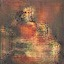

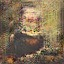



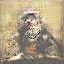

#**SONUÇ :**
###İnsanlık tarhi boyunca sanat,edebiyat gibi unsurlar hep insana ait olmuştur. Ancak günümüz yapay zeka teknolojileri vasıtasıyla sanatsal  aktiviteler artık makineler tarafından da icra edebilmektedir. Bu durum geleneksel sanat anlayışını sorgulamamızı neden olurken aynı zamanda teknolojinin insan yaratıcılığına etkisi de tartışmaya sebep olur. Kendimize **"insanı makineden ayıran nedir ?"** diye sorduğumuzada duygular,empati,yaratıcılık gibi kavramlar öne çıkar ancak günümüzde artık makine bu konularda bile insandan daha insandır.

###**Mustafa Özcan**






###**Yunus Emre Yılmaz**






###**Hatice Turan**






###**Yahya Haliloğlu**




